In [1]:
from os import listdir
from os.path import isfile, join
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import signal

In [2]:
test_dir="F:\\2_10_2020 Raw Data L3\\"
sav_dir="F:\\L3 Raw Data\\"
test_files=listdir(test_dir)

all_stations=[]
station_label=[]
station_loc=listdir(test_dir)
for i in range(len(station_loc)):
    station_name=listdir(test_dir+station_loc[i]+"\\")
    station_label.append(station_name)
    for j in range(len(station_name)):        
        holder=listdir(test_dir+station_loc[i]+"\\"+
                    station_name[j]+"\\Level3\\")
        
        holder=[test_dir+station_loc[i]+"\\"+
                    station_name[j]+"\\Level3\\"+x +"\\"for x in holder]
        all_stations.append(holder)

tests=np.array(all_stations)

# Returns lists for all the years where we collected data, for reach sensor.
# Some sensors have many years. all_stations[i][j] is the j'th year of the ith
# station. station_label[i] is the name of the ith station to keep organized
all_stations=tests.flatten()
station_label = [item for sublist in station_label for item in sublist]


In [4]:
# Takes an array of station years, imports all of the data and saves it.
# Format is [Minutes UTC, Residual Gravity (g)].
# Saves it to the savedir drectory, with the name stationlabel

def Process_Station(station_files,savedir,stationlabel):
    test_files=station_files
    save_dir=savedir
    save_name=stationlabel
    save_dir+save_name

    # # # This checks the Raw data Visually
    res_full=np.array([])
    time_full=np.array([])

    for j in range(len(test_files)):
        all_files=listdir(test_files[j])
        for i in range(len(all_files)):
            cur_file=test_files[j]+all_files[i]
            with open(cur_file) as f:
                content=f.readlines()
                pdtest=pd.Series(content)
                start_index = [i for i, s in enumerate(content[0:40]) if '77777' in s][0]+1
                end_index = ([i for i, s in enumerate(content[-40:-1]) if '8888888' in s][0]-40)-1
                testt=pdtest.str[15:25][start_index:end_index].str.strip().values.astype(np.float)
                res_fil=(1e-9)*testt
                res_full=np.hstack([res_full,res_fil])
                year=pdtest.str[0:4][start_index :end_index].str.strip().astype(np.int).values
                month=pdtest.str[4:6][start_index :end_index].str.strip().astype(np.int).values
                day=pdtest.str[6:9][start_index :end_index].str.strip().astype(np.int).values
                hour=pdtest.str[9:11][start_index :end_index].str.strip().replace('',0).astype(np.int).values
                minute=pdtest.str[11:13][start_index :end_index].str.strip().replace('',0).astype(np.int).values
                time_fil=(year-1970)*525600+month*43800+day*1400+hour*60+minute
                time_full=np.hstack([time_full,time_fil])

    np.save(save_dir+save_name,[time_full,res_full])

In [5]:
#Where we will save the processed data
save_dir="F:\\L3 Raw Data\\"

# Process all the data, combing individual files into long time series per sensor.
# for i in range(len(all_stations)):
#     Process_Station(all_stations[i],save_dir,station_label[i])

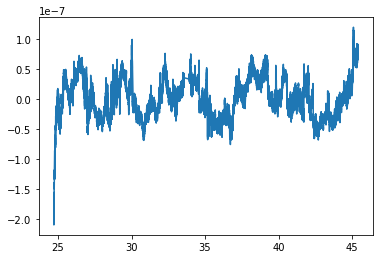

In [6]:
aaa=np.load(save_dir+station_label[17]+".npy",allow_pickle=True)
testtime=aaa[0]/525600
testg=aaa[1]
plt.plot(testtime,testg)
plt.show()

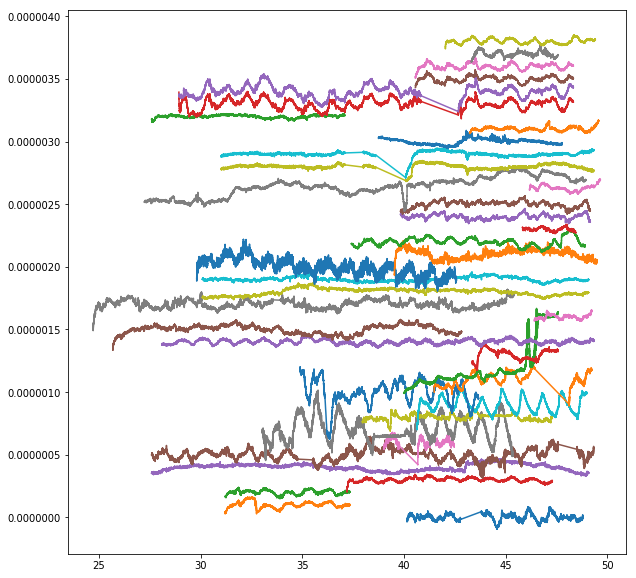

In [7]:
f,ax = plt.subplots(1, figsize=(10,10))

for i in range(len(station_label)):
    aaa=np.load(save_dir+station_label[i]+".npy",allow_pickle=True)
    testtime=aaa[0]/525600
    testg=aaa[1]+i*1e-7
    plt.plot(testtime,testg)


plt.show()

In [8]:
def Sig_Gen(tm,t0,w,amp):
    s=[]
    t=[]
    for i in range(tm):
        s.append(((np.sqrt(2*np.exp(1)))/w)*amp*(i-t0)*np.exp(-(i-t0)**2/(w**2)))
        t.append(i)
    return np.array(t), np.array(s)


def TS_Correlations_Fast(time,data,kernel):
    output=signal.correlate(data,kernel,mode='same',method='fft')
    return(time,output)

def Signal_Search(tvec,resvec):
    width_vec=[]
    max_vec=[]
    std_vec=[]
    swidth=5

    while swidth < len(tvec)/5:
        tmask, kernel=Sig_Gen(int(swidth*7),int(swidth*7/2),swidth,1)
        kernel=0.968*np.sqrt(2)*kernel/np.sum(np.abs(kernel))


        tconv,sigconv=TS_Correlations_Fast(tvec,resvec,kernel)
        max_vec.append(np.max(np.abs(sigconv)))
        std_vec.append(np.std(sigconv))
        width_vec.append(swidth)

        swidth=swidth*1.2
    
    return width_vec, std_vec, max_vec



In [9]:
width_vec=[]
std_vec=[]
max_vec=[]

# for i in range(len(all_stations)):
# #for i in range(2):
#     aaa=np.load(save_dir+station_label[i]+".npy",allow_pickle=True)
#     testtime=aaa[0]
#     testg=aaa[1]
#     a,b,c = Signal_Search(testtime,testg)
    
#     save_name=station_label[i]+"lim"
    
#     np.save(save_dir+save_name,[a,b,c])
#     width_vec.append(a)
#     std_vec.append(b)
#     max_vec.append(c)

C:\Users\Rees\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\signaltools.py:491: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return x[reverse].conj()


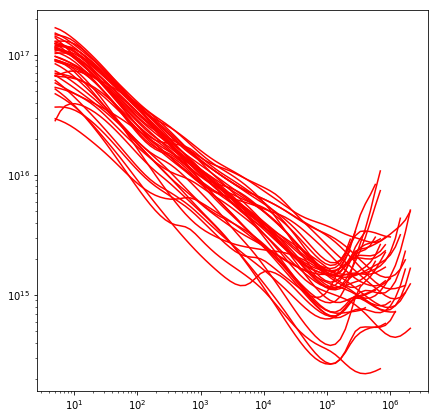

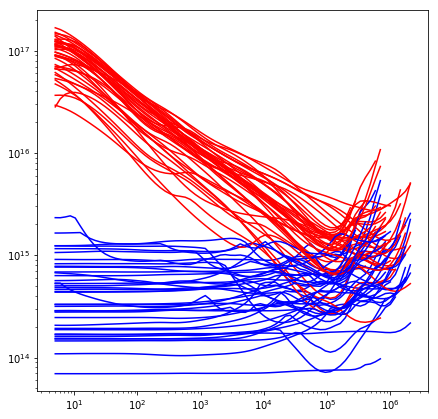

In [22]:
f,ax = plt.subplots(1, figsize=(7,7))
for i in range(len(all_stations)):
    a,b,c=np.load(save_dir+station_label[i]+"lim"+".npy",allow_pickle=True)
    Lambda_Limit=2.1*1e7/c
    Lambda_Std=2.1*1e7/b
    plt.loglog(a,Lambda_Std,color='r')
    #plt.plot(a,Lambda_Limit,color='b')
plt.show()

f,ax = plt.subplots(1, figsize=(7,7))
for i in range(len(all_stations)):
    a,b,c=np.load(save_dir+station_label[i]+"lim"+".npy",allow_pickle=True)
    Lambda_Limit=2.1*1e7/c
    Lambda_Std=2.1*1e7/b
    plt.loglog(a,Lambda_Std,color='r')
    plt.loglog(a,Lambda_Limit,color='b')
plt.show()